In [1]:
import re
import keras
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.manifold import TSNE
# from keras.optimizers import RMSprop
from tensorflow.keras.optimizers import RMSprop
from keras.models import Sequential
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from keras.layers import Dropout, Dense, BatchNormalization
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
import matplotlib


font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

df = pd.read_csv(r'C:\Users\mkahs\Repository\SPAM-BERT\Encoded_data.csv')
df.head()

,spam,original_message,0,1,2,3,4,5,6,7,...,758,759,760,761,762,763,764,765,766,767
0,0,"Go until jurong point, crazy.. Available only ...",-0.142966,-0.225385,0.268060,0.065721,-0.100784,-0.198442,0.390656,0.337181,...,0.069543,-0.396520,0.011689,-0.208539,0.012130,-0.056947,-0.025428,-0.057884,0.165974,0.302198
1,0,Ok lar... Joking wif u oni...,-0.244984,-0.052506,0.137510,-0.623836,-0.311277,0.074931,0.652978,0.200019,...,0.070855,-0.541657,-0.040561,0.047741,-0.063777,-0.138928,0.041252,-0.045966,0.087562,0.546936
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,-0.389005,-0.030240,0.203487,-0.166000,0.020918,-0.139902,0.331639,0.095457,...,0.381351,-0.158719,-0.000505,-0.167245,0.169160,-0.084802,-0.366647,-0.106075,0.096242,0.567941
3,0,U dun say so early hor... U c already then say...,-0.090251,0.151952,0.069051,-0.610341,-0.220990,0.013123,0.301813,0.334780,...,0.196930,-0.408126,0.062470,0.140425,0.175495,-0.085699,-0.226141,-0.002506,0.255286,0.496604
4,0,"Nah I don't think he goes to usf, he lives aro...",0.056019,0.251126,-0.092620,-0.307522,-0.365733,-0.075227,0.414467,0.388033,...,-0.168950,-0.419399,-0.070503,-0.010642,0.323683,0.016842,-0.103515,-0.076240,0.479977,0.274191


C:\Users\mkahs\AppData\Local\Temp/ipykernel_11888/977115516.py:10: UserWarning: Legend does not support 'H' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend("Ham", "Spam")
C:\Users\mkahs\AppData\Local\Temp/ipykernel_11888/977115516.py:10: UserWarning: Legend does not support 'a' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend("Ham", "Spam")
C:\Users\mkahs\AppData\Local\Temp/ipykernel_11888/977115516.py:10: UserWarning: Legend does not support 'm' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend("Ham", "Spam")


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


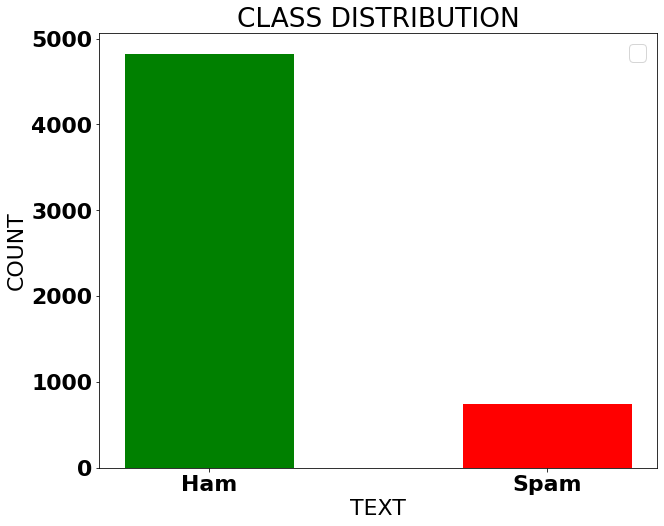

In [2]:
plt.subplots(figsize=(10,8))
# ax = sns.countplot(x="spam", data=df)
data_dict ={'Ham':4825,'Spam':747}
classes= list(data_dict.keys())
values = list(data_dict.values())
plt.bar(classes, values, color= {'green', 'red'},width = 0.5)
plt.title("CLASS DISTRIBUTION")
plt.xlabel("TEXT")
plt.ylabel("COUNT")
plt.legend("Ham", "Spam")

In [3]:
df["spam"].value_counts()

0    4825
1     747
Name: spam, dtype: int64

In [4]:
# Count the number of words in the message
df["num_words"] = df["original_message"].apply(lambda s: len(re.findall(r'\w+', s)))

# Get the length of the text message
df["message_len"] = df["original_message"].apply(len)

# Count the number of uppercased characters
df["num_uppercase_chars"] = df["original_message"].apply(lambda s: sum(1 for c in s if c.isupper())) 

# Count the numbe rof uppercased words
df["num_uppercase_words"] = df["original_message"].apply(lambda s: len(re.findall(r"\b[A-Z][A-Z]+\b", s)))

# Check if the message contains the word "free" or "win"
df["contains_free_or_win"] = df["original_message"].apply(lambda s: int("free" in s.lower() or "win" in s.lower()))

In [5]:
# Initialize StandardScaler
scaler = preprocessing.StandardScaler()

# Dont standerdize binary columns and the text column
feats_to_scale = df.drop(["spam", "original_message", "contains_free_or_win"], axis=1)

# Create a new dataframe with the standardized features
scaled_features = pd.DataFrame(scaler.fit_transform(feats_to_scale))
scaled_features.rename(
    {768: "num_words", 769:"message_len", 770: "num_uppercase_chars", 771: "num_uppercase_words"},
    axis=1,
    inplace=True
)

# Update the dataset with the new standerdized features
scaled_df = df.copy()
scaled_df.update(scaled_features)

In [6]:
X = scaled_df.drop(["spam", "original_message"], axis=1)
y = scaled_df["spam"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [7]:
X_embedded = TSNE(n_components=2, random_state=42).fit_transform(X_train)

C:\Users\mkahs\anaconda3\envs\RTX2080\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\mkahs\anaconda3\envs\RTX2080\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [8]:
# creating the dataframe for plotting
def creat_plotting_data(data, labels=y_train, rename=False):
    """Creates a dataframe from the given data, used for plotting"""
    
    df = pd.DataFrame(data)
    df["spam"] = labels.to_numpy()
    
    if rename:
        df.rename({0:"Ham", 1:"Spam"}, axis=1, inplace=True)
        
    return df

# creating the dataframes for plotting
plotting_data_embedded = creat_plotting_data(X_embedded, rename=True)

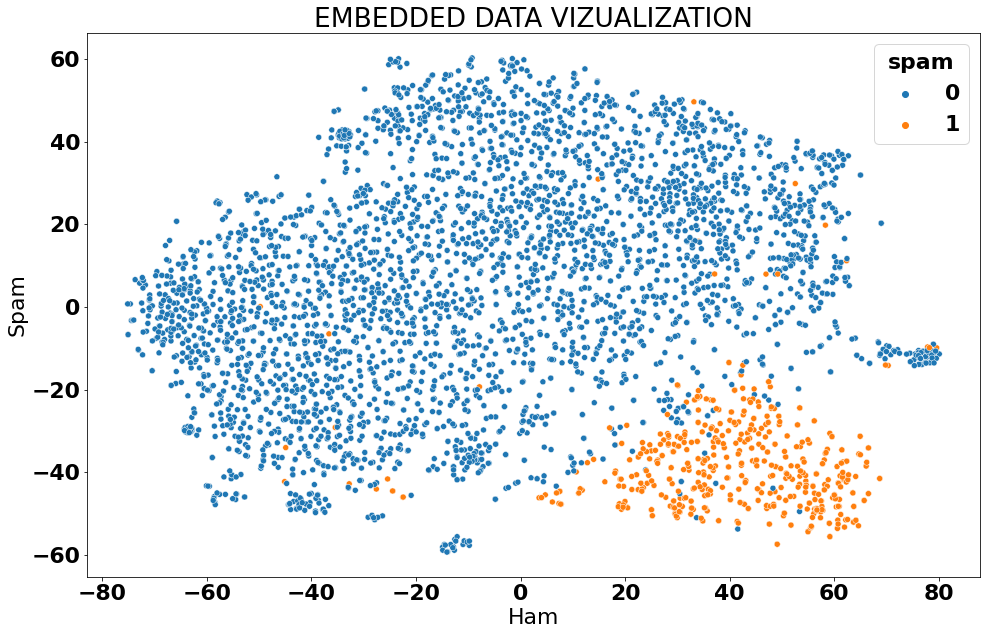

In [9]:
plt.figure(figsize=(16, 10))
ax = sns.scatterplot(x="Ham", y="Spam", hue="spam", data=plotting_data_embedded)
# ax.set(title = "Spam messages are generally closer together due to the BERT embeddings")
ax.set(title = "EMBEDDED DATA VIZUALIZATION")
plt.show()

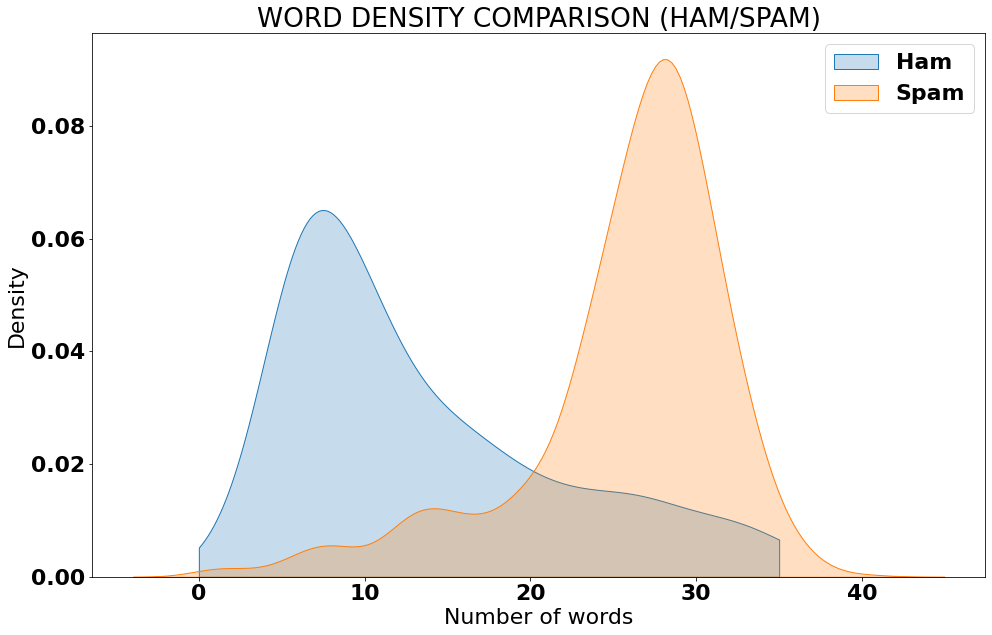

In [10]:
_,ax = plt.subplots(figsize=(16,10))
sns.kdeplot(df.loc[df.spam == 0, "num_words"], shade=True, label="Ham", clip=(0, 35)) # removing observations with message length above 35 because there is an outlier
sns.kdeplot(df.loc[df.spam == 1, "num_words"], shade=True, label="Spam")
# ax.set(xlabel = "Number of words", ylabel = "Density",title = "Spam messages have more words than ham messages")
ax.set(xlabel = "Number of words", ylabel = "Density",title = "WORD DENSITY COMPARISON (HAM/SPAM)")
plt.legend(['Ham','Spam'])
plt.show()

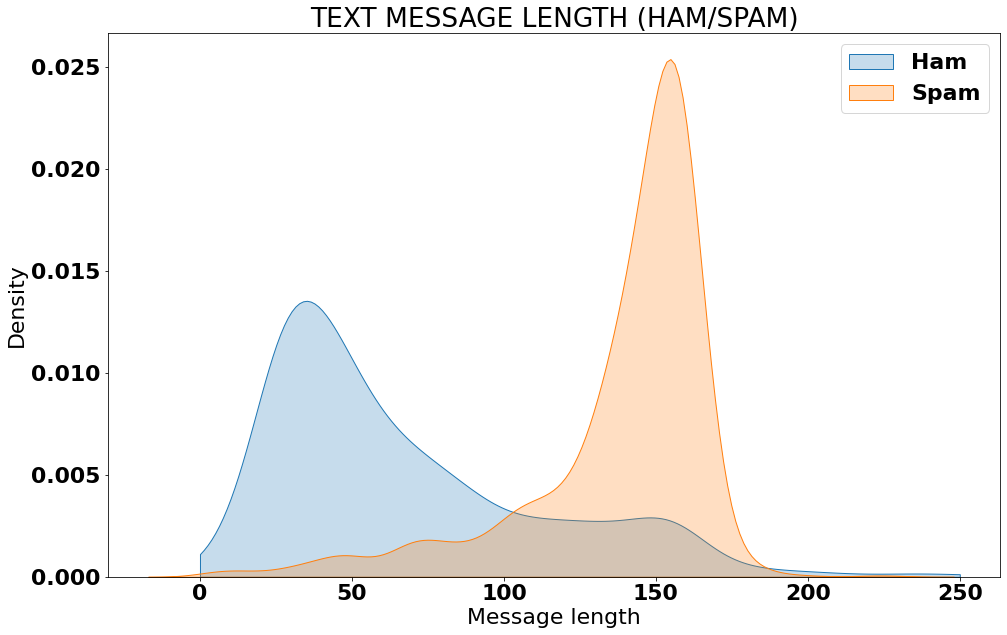

In [11]:
_,ax = plt.subplots(figsize=(16,10))
sns.kdeplot(df.loc[df.spam == 0, "message_len"], shade=True, label="Ham", clip=(0, 250)) # removing observations with message length above 250 because there is an outlier
sns.kdeplot(df.loc[df.spam == 1, "message_len"], shade=True, label="Spam")
ax.set(xlabel = "Message length", ylabel = "Density",title = "TEXT MESSAGE LENGTH (HAM/SPAM)")
plt.legend(['Ham','Spam'])
plt.show()

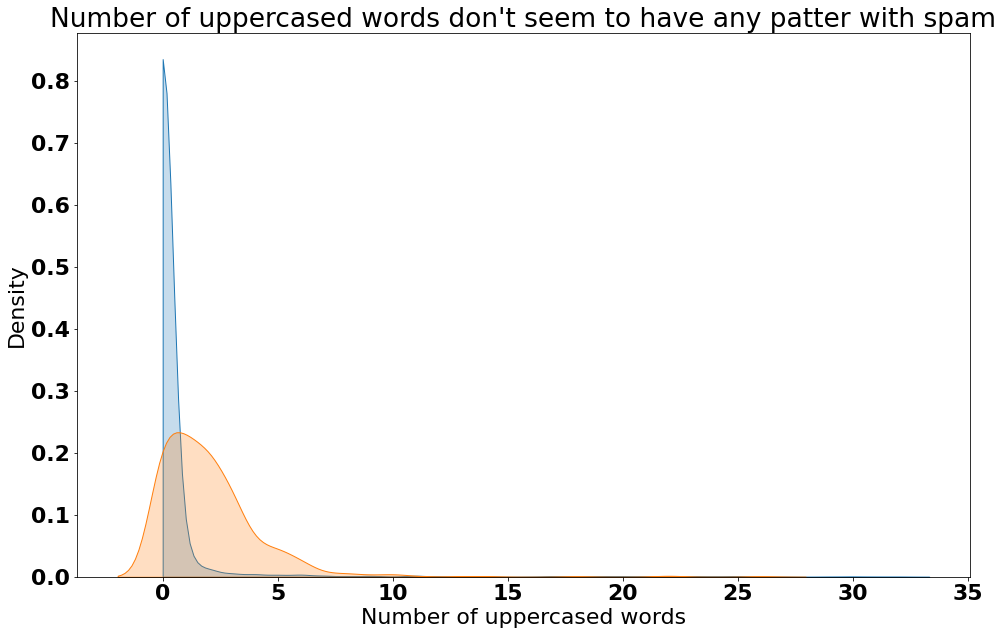

In [12]:
_,ax = plt.subplots(figsize=(16,10))
sns.kdeplot(df.loc[df.spam == 0, "num_uppercase_words"], shade=True, label="Ham", clip=(0, 250)) # removing observations with message length above 250 because there is an outlier
sns.kdeplot(df.loc[df.spam == 1, "num_uppercase_words"], shade=True, label="Spam")
ax.set(xlabel = "Number of uppercased words", ylabel = "Density",title = "Number of uppercased words don't seem to have any patter with spam")
plt.show()

   spam  contains_free_or_win  Percentage of group
0     0                     0             0.972850
1     0                     1             0.027150
2     1                     0             0.630522
3     1                     1             0.369478


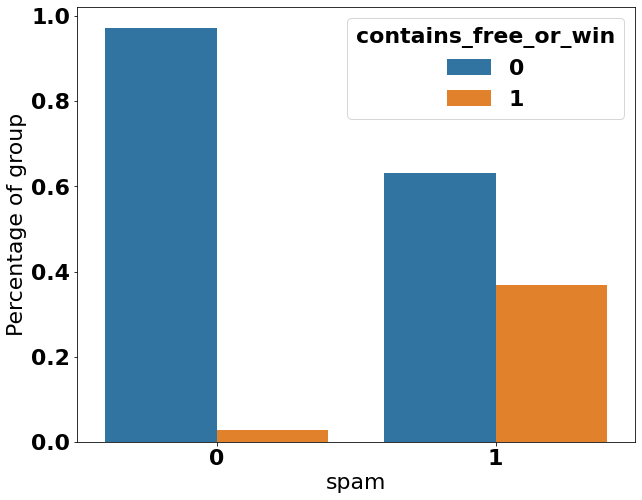

In [13]:
plt.subplots(figsize=(10,8))

# Get the proportion of the genders grouped by the attrition status
grouped_data = df.groupby("spam")["contains_free_or_win"].value_counts(normalize = True).rename("Percentage of group").reset_index()
print(grouped_data)

# Plot the result
ax = sns.barplot(x="spam", y="Percentage of group", hue="contains_free_or_win", data=grouped_data)
# plt.title=()"GROUPING OF TEXT BASED ON WORD (WIN/FREE)"

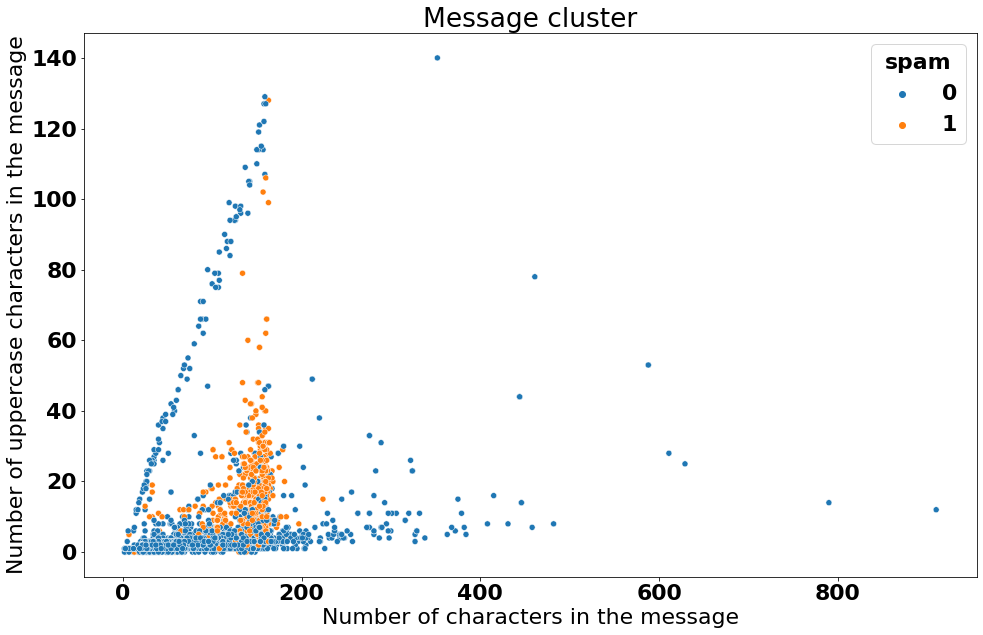

In [20]:
plt.subplots(figsize=(16,10))
ax = sns.scatterplot(x="message_len", y="num_uppercase_chars", hue="spam", data=df)
ax.set(
    xlabel="Number of characters in the message",
    ylabel="Number of uppercase characters in the message",
#     title="Spam messages are clustered together. There is a strong linear pattern for ham messages with high number of uppercase characters")
    title="Message cluster")
plt.show()

In [ ]:
# 

In [ ]:
model = Sequential()

model.add(Dense(1000, input_shape=(773,), activation="relu"))
model.add(BatchNormalization(axis=-1))

model.add(Dense(256, activation="relu"))
model.add(BatchNormalization(axis=-1))
model.add(Dropout(0.25))

model.add(Dense(256, activation="relu"))
model.add(BatchNormalization(axis=-1))
model.add(Dropout(0.5))

model.add(Dense(128, activation="relu"))
model.add(BatchNormalization(axis=-1))
model.add(Dropout(0.25))

model.add(Dense(10, activation="relu"))
model.add(BatchNormalization(axis=-1))
model.add(Dropout(0.25))

model.add(Dense(1, activation="sigmoid"))

In [ ]:
# defining the learning rate, the number of epochs and the batch size
INIT_LR = 0.001
NUM_EPOCHS = 30
BS = 64
opt = RMSprop(lr = INIT_LR)

# This is just a necessary step to compile the model, we don't actually need it because we're not using the old model
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])

# Reduce the learning rate by half if validation accuracy has not increased in the last 3 epochs
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, min_lr=0.00001)

fitted_network = model.fit(X_train, y_train, validation_split=0.2, batch_size=BS, epochs=NUM_EPOCHS, callbacks=[learning_rate_reduction])

In [ ]:
# predict results
preds = np.round(model.predict(X_test)).flatten()

# Plot confusion matrix
plt.figure(figsize=(10,4))
heatmap = sns.heatmap(data = pd.DataFrame(confusion_matrix(y_test, preds)), annot = True, fmt = "d", cmap=sns.color_palette("Reds", 50))
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
plt.ylabel('Ground Truth')
plt.xlabel('Prediction')
plt.show()

# Print accuracy, ROC and classification report for the test-set
print(f"""Accuray: {round(accuracy_score(y_test, preds), 5) * 100}%
ROC-AUC: {round(roc_auc_score(y_test, preds), 5)}""")
print(classification_report(y_test, preds))